## Load data

In [1]:
import os
os.chdir('..')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from src.dataset import *
from src.model import *
from src.train_test import *
import matplotlib.pyplot as plt
import pandas as pd
from torch import optim
from src.vis import *
from src.gradient import *
from scipy.spatial.distance import cdist

In [3]:
batch_size = 32
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
# load data
train_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=True)
test_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=False)    


Files already downloaded and verified
Files already downloaded and verified


## Original model

  1%|          | 11/1563 [00:00<00:14, 104.69it/s]

Trail 1


  1%|          | 11/1563 [00:00<00:14, 106.52it/s]

Trail 2


  1%|          | 10/1563 [00:00<00:16, 96.68it/s]

Trail 3


  1%|          | 11/1563 [00:00<00:14, 108.37it/s]

Trail 4


  1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Trail 5


100%|██████████| 1563/1563 [00:15<00:00, 103.11it/s]


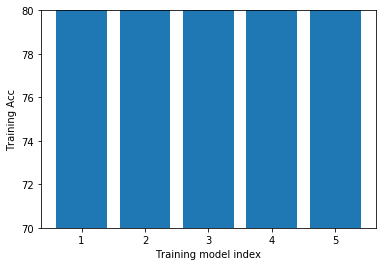

Average training acc: 99.66720000000001


[99.994, 99.998, 99.998, 99.998, 98.348]

In [61]:
model_name = 'CIFAR17_add242456'

# initialize model
model = ChildModel(extra_filter=[24, 24, 56])
model = model.to(device)

plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', 
                  total_trails=5,
                  vis=True, logger=None)

# plot_training_acc(model, test_data_loader,
#                   model_name=model_name, data_name='CIFAR10', 
#                   total_trails=5,
#                   vis=True, logger=None)

  1%|          | 14/1563 [00:00<00:11, 134.16it/s]

Trail 1


  1%|          | 14/1563 [00:00<00:11, 136.74it/s]

Trail 2


  1%|          | 14/1563 [00:00<00:11, 136.21it/s]

Trail 3


  1%|          | 14/1563 [00:00<00:11, 135.44it/s]

Trail 4


  1%|          | 14/1563 [00:00<00:11, 134.31it/s]

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 137.54it/s]


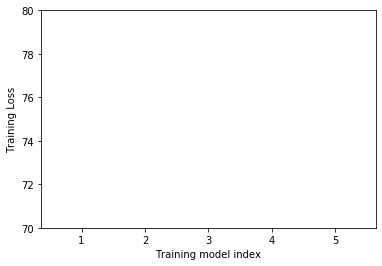

Average training loss: 0.011648704625606538


[0.003996546618938446,
 0.001760293550491333,
 0.001138269715309143,
 0.00032009347915649413,
 0.05102831976413727]

In [59]:
plot_training_loss(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10',
                  total_trails=5, 
                  vis=True, logger=None)

### Get pos_grad_dict and neg_grad_dict for anchor model

In [21]:
# initialize model
model_name = 'CIFAR17_add010005' # change this
model = ChildModel(extra_filter=[1, 0, 5]) # change this
model = model.to(device)

pos_grad_dict, neg_grad_dict = get_graddict_single(model=model, 
                                                   model_name=model_name, 
                                                   data_name='CIFAR10',
                                                   train_data_loader=train_data_loader, 
                                                   trail=1, 
                                                   compute_index=True, 
#                                             compute_index=False, 
                                                   save=True)

  1%|          | 14/1563 [00:00<00:11, 130.75it/s]

Compute correctly predicted data indices...
ChildModel(
  (body): Sequential(
    (cnn1): Sequential(
      (conv): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn2): Sequential(
      (conv): Conv2d(9, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn3): Sequential(
      (conv): Conv2d(8, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (head): Sequential(
    (dense): Sequential(
      (fc1): Conv2d(208, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
      (fc2): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)
CIFAR17_

100%|██████████| 1563/1563 [00:12<00:00, 129.92it/s]


Files already downloaded and verified
Files already downloaded and verified


  1%|          | 6/610 [00:00<00:11, 52.78it/s]

Number of postive samples:  610
Number of negative samples:  173
Use trail 1 to compute conflicting gradients


  3%|▎         | 6/173 [00:00<00:03, 53.80it/s]

Length of data 38991


100%|██████████| 173/173 [00:03<00:00, 53.98it/s]

Length of data 11009


In [22]:
# avg of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
#         print(conflict_level.shape)
        layer_conflict_level = conflict_level.mean().item()
        print(layer_conflict_level)

0.02361026033759117
0.009879130870103836
0.01562679000198841
0.002811567857861519
0.01969051919877529


### Get pos_grad_dict and neg_grad_dict for neighbor model

In [129]:
# initialize model
model_name = 'CIFAR17_add000003' # change this
neighbor_name = 'CIFAR17_add000004' # change this
neighbor_model = ChildModel(extra_filter=[0,0,4],
#                             parent_dict_path=None,
                           parent_dict_path= 'checkpoints/{}-{}-model{}/199.pt'.format(model_name, 'CIFAR10', str(1))
                           ) # change this
neighbor_model = neighbor_model.to(device)

pos_grad_dict, neg_grad_dict = get_neighbor_graddict_single(
                          model_name=model_name,
                          neighbor_model=neighbor_model,
                          neighbor_model_name=neighbor_name,
                          data_name='CIFAR10',
                          train_data_loader=train_data_loader,
                          trail=1,
                          retrain=False)

Layer body.cnn3.conv.weight has been mutated, call dynamic inheritance
Layer body.cnn3.conv.bias has been mutated, call dynamic inheritance
Layer head.dense.fc1.weight has been mutated, call dynamic inheritance
Files already downloaded and verified
Files already downloaded and verified


  1%|          | 6/587 [00:00<00:11, 52.59it/s]

Number of postive sample batches:  587
Number of negative sample batches:  195
Use trail 1 to compute conflicting gradients


  3%|▎         | 6/195 [00:00<00:03, 52.64it/s]

Length of data 37561


100%|██████████| 195/195 [00:03<00:00, 51.94it/s]

Length of data 12439


In [130]:
# avg of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name:
        grad_neg = neg_grad_dict[name]
#         print(grad_pos)
#         print(grad_neg)
        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
#         print(conflict_level.shape)
        layer_conflict_level = conflict_level.mean().item()
        print(layer_conflict_level)

0.045263078063726425
0.0
0.015963401645421982
0.003962127026170492
0.022421449422836304


### Get gradients for all examples

In [103]:
# model_name = 'CIFAR17_add010003'

# # initialize model
# model = ChildModel(extra_filter=[1, 0, 3])
# checkpoint = 'checkpoints/{}-{}-model{}/199.pt'.format(model_name, 'CIFAR10', str(1))
# model.load_state_dict(torch.load(checkpoint))
# model = model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001) # this optimizer is dummy
# criterion=nn.CrossEntropyLoss(reduction='sum')

parent = 'CIFAR17_add010003'
model_name = 'CIFAR17_add010004' # change this
model = ChildModel(extra_filter=[1,0,4],
#                 parent_dict_path=None,
                   parent_dict_path= 'checkpoints/{}-{}-model{}/199.pt'.format(parent, 'CIFAR10', str(1))
                   ) # change this
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) # this optimizer is dummy
criterion=nn.CrossEntropyLoss(reduction='sum')

Layer body.cnn3.conv.weight has been mutated, call dynamic inheritance
Layer body.cnn3.conv.bias has been mutated, call dynamic inheritance
Layer head.dense.fc1.weight has been mutated, call dynamic inheritance


In [104]:
grad_dict = dict()
model.train() # enable gradient flow
data_ct = 0
for data in tqdm(train_data_loader):
    img, target = data
    img = img.to(device)
    target = target.to(device)
    data_ct += img.shape[0]

    output = model.forward(img)

    # zero the parameter gradients
    optimizer.zero_grad()
    loss = criterion(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        grad = param.grad.detach().clone().cpu()
        if 'weight' in name:
            if name not in grad_dict.keys():
                grad_dict[name] = grad.mean(dim=tuple(range(1, len(grad.shape)))) # average over each cnn filter
            else:
                grad_dict[name] = torch.add(grad_dict[name], grad.mean(dim=tuple(range(1, len(grad.shape))))) # sum the 

100%|██████████| 1563/1563 [00:19<00:00, 80.96it/s]


In [105]:
# avg of weight contradiction level for each layer
for name, grad in grad_dict.items():
    if 'weight' in name:
        balance_level = torch.abs(grad).mean().item()
        print(balance_level)


1387.4742431640625
786.0296630859375
882.1444702148438
127.3050765991211
1889.228271484375


## Evolution Trace

### Get trace

In [109]:
# for folder in os.listdir('checkpoints/'):
#     if folder.startswith('CIFAR17-CIFAR10-model'):
#         os.rename(os.path.join('checkpoints/', folder),
#                  os.path.join('checkpoints/', 
#                               'CIFAR17_add000-CIFAR10-model'+folder.split('CIFAR17-CIFAR10-model')[1]))

In [131]:
initial_trace = ['CIFAR17_add000000']

logfile = open('log/train_trace.log').readlines()
for j in logfile:
    if 'INFO:trace:Update model name' in j:
        initial_trace.append(j.strip().split(' ')[-1])

In [132]:
initial_trace

['CIFAR17_add000000',
 'CIFAR17_add000001',
 'CIFAR17_add000002',
 'CIFAR17_add000003',
 'CIFAR17_add010003',
 'CIFAR17_add010004',
 'CIFAR17_add010005',
 'CIFAR17_add010006',
 'CIFAR17_add010007',
 'CIFAR17_add010008',
 'CIFAR17_add010009',
 'CIFAR17_add010109',
 'CIFAR17_add010110',
 'CIFAR17_add010111',
 'CIFAR17_add010112',
 'CIFAR17_add020112',
 'CIFAR17_add020113',
 'CIFAR17_add020114',
 'CIFAR17_add020115',
 'CIFAR17_add030115',
 'CIFAR17_add030215',
 'CIFAR17_add030315',
 'CIFAR17_add030316',
 'CIFAR17_add030317',
 'CIFAR17_add030318',
 'CIFAR17_add030319',
 'CIFAR17_add040319',
 'CIFAR17_add040320',
 'CIFAR17_add050320',
 'CIFAR17_add050321',
 'CIFAR17_add050421',
 'CIFAR17_add050422',
 'CIFAR17_add060422']

### Stacked bar chart of contradicted samples

In [24]:
pos_unique_trace = []
pos_overlap_trace = []
neg_unique_trace = []
neg_overlap_trace = []


for i, model in enumerate(initial_trace):
    pos_index = np.load('./datasets/{}_train_pos_index_{}.npy'.format('CIFAR10', model))
    neg_index = np.load('./datasets/{}_train_neg_index_{}.npy'.format('CIFAR10', model))
    
    if i == 0:
        num_pos_unique = len(pos_index)
        num_pos_overlap = 0
        num_neg_unique = len(neg_index)
        num_neg_overlap = 0        
    else:
        num_pos_overlap = len(set(pos_index).intersection(set(last_pos_index)))
        num_pos_unique = len(pos_index) - num_pos_overlap
        num_neg_overlap = len(set(neg_index).intersection(set(last_neg_index)))
        num_neg_unique = len(neg_index) - num_neg_overlap
        
    last_pos_index = pos_index
    last_neg_index = neg_index
    
    pos_unique_trace.append(num_pos_unique)
    pos_overlap_trace.append(num_pos_overlap)    
    neg_unique_trace.append(num_neg_unique)
    neg_overlap_trace.append(num_neg_overlap)    

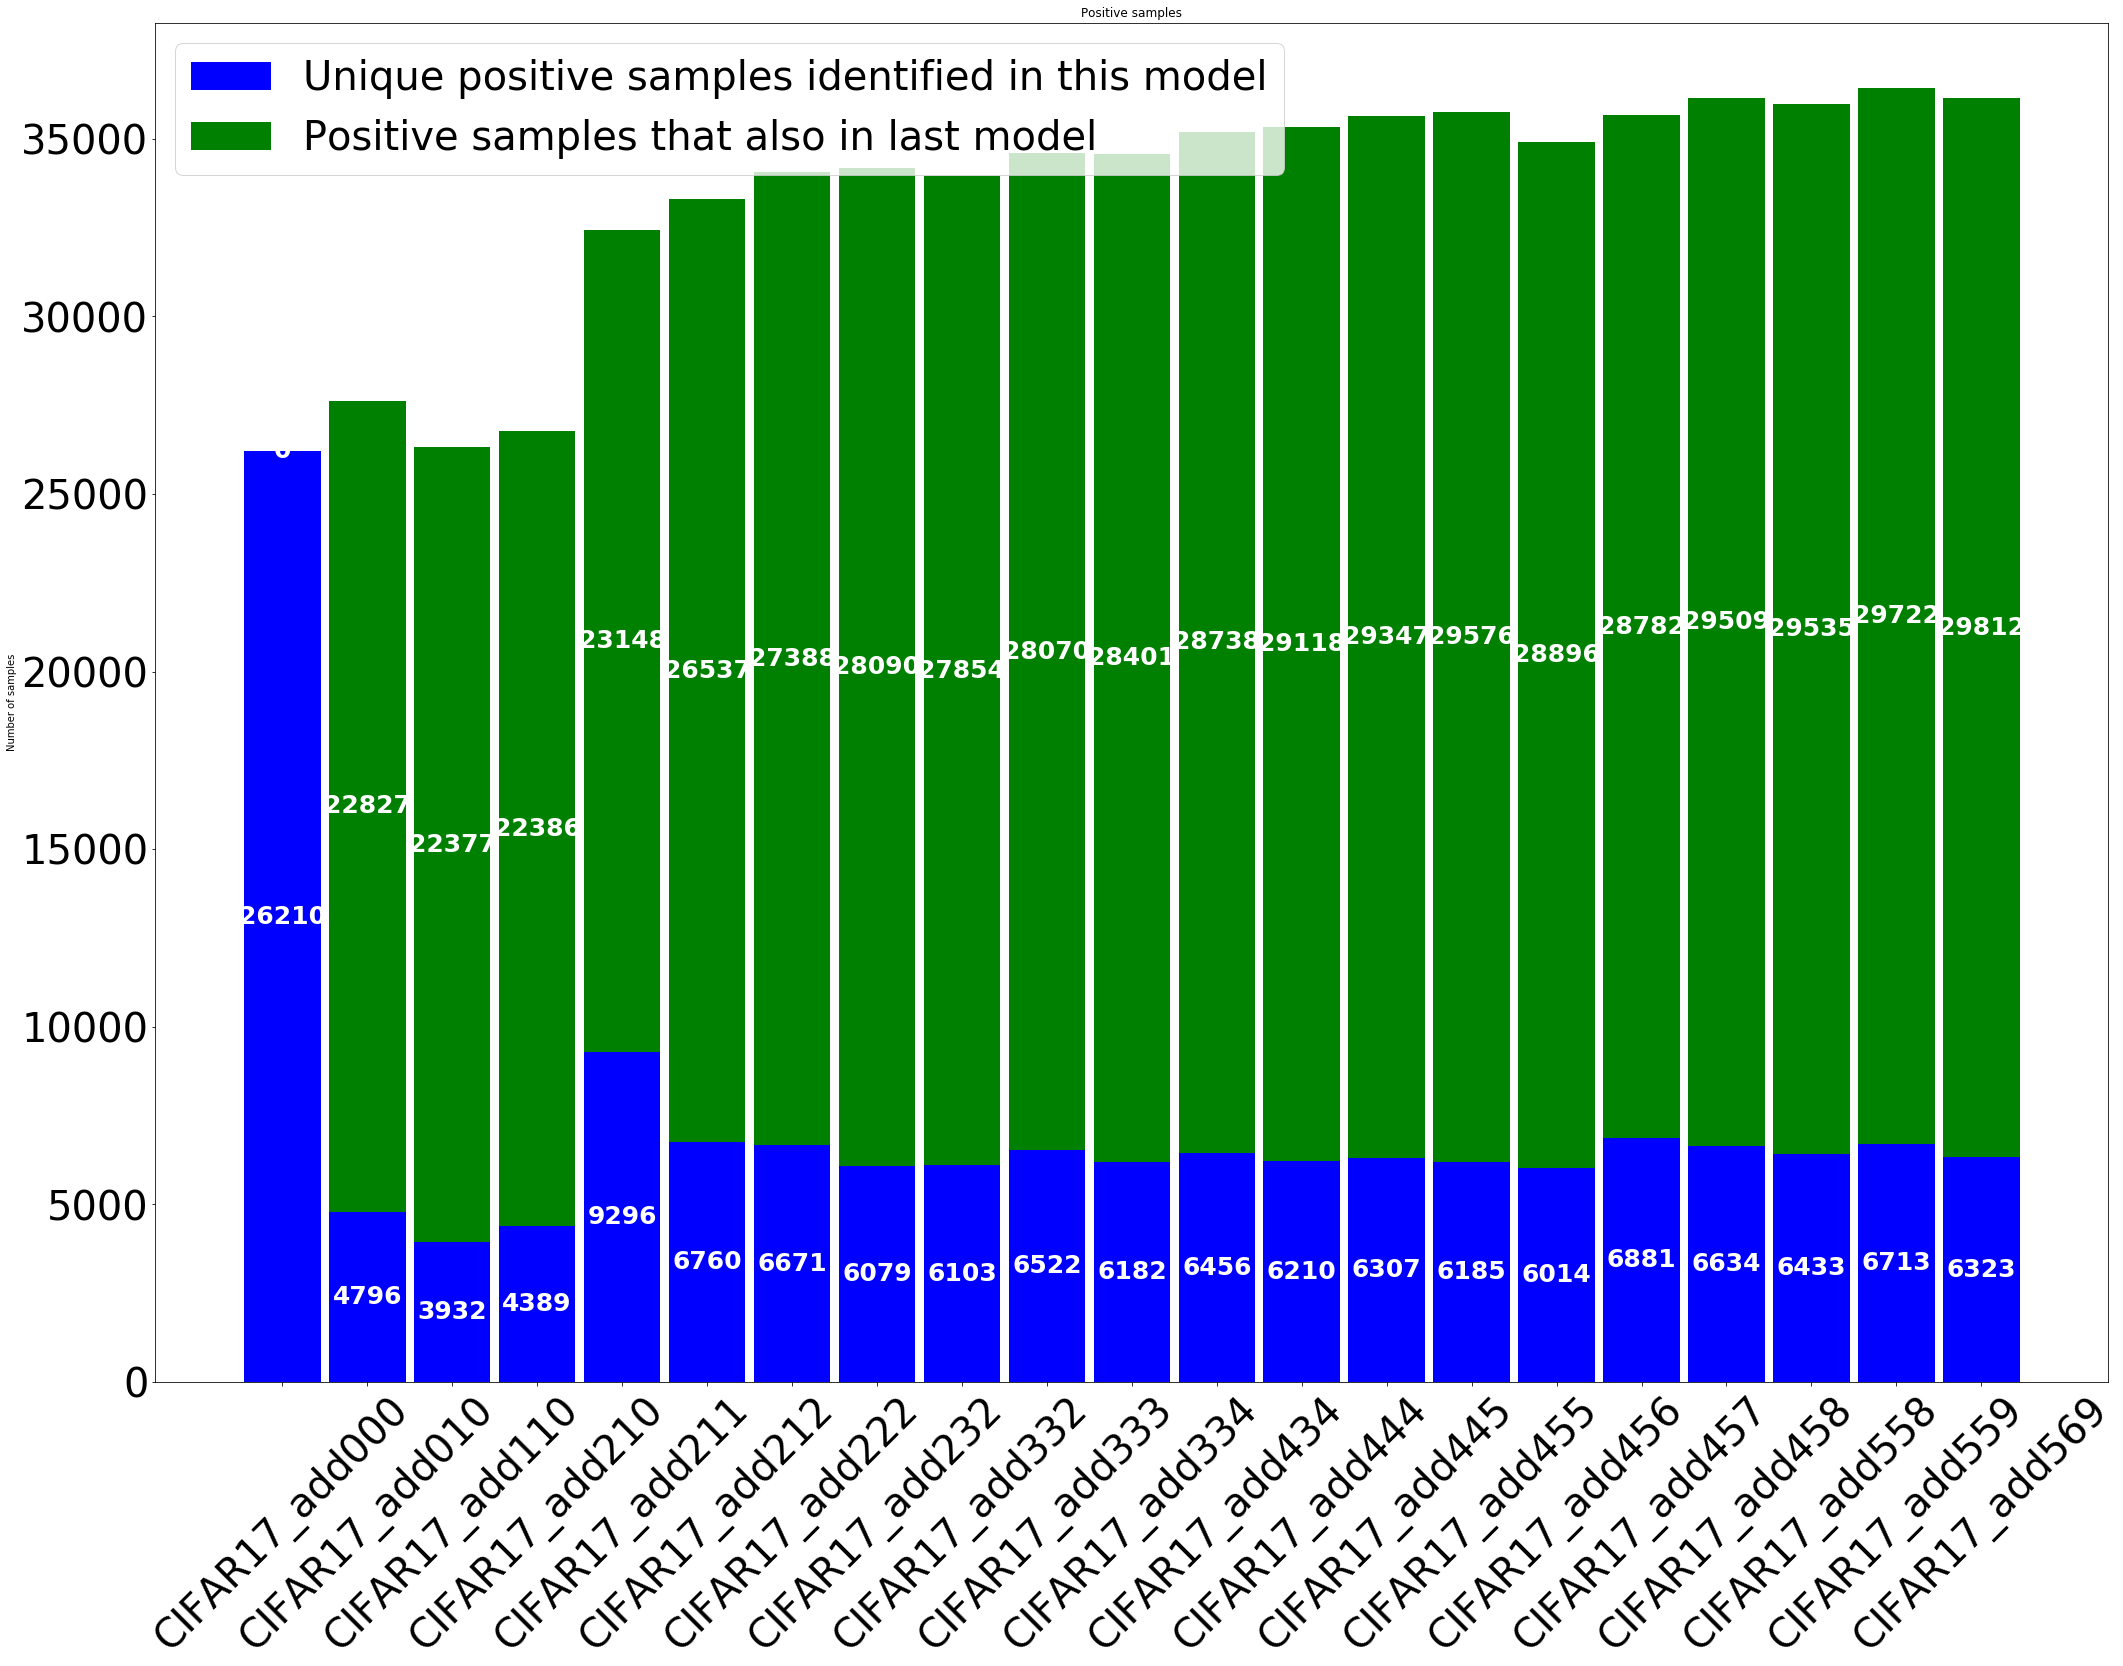

In [55]:
labels = initial_trace
unique = pos_unique_trace
overlap = pos_overlap_trace
width = 0.9 # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(35,25))

ax1 = ax.bar(labels, unique, width,  label='Unique positive samples identified in this model', color='blue')
ax2 = ax.bar(labels, overlap, width, bottom=unique, label='Positive samples that also in last model', color='green')

#  add value labels
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=25, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=25, fontweight="bold")


ax.set_ylabel('Number of samples')
ax.set_title('Positive samples')
ax.legend(fontsize=40)
plt.xticks(rotation=45, fontsize=40)
plt.yticks(fontsize=40)

plt.show()

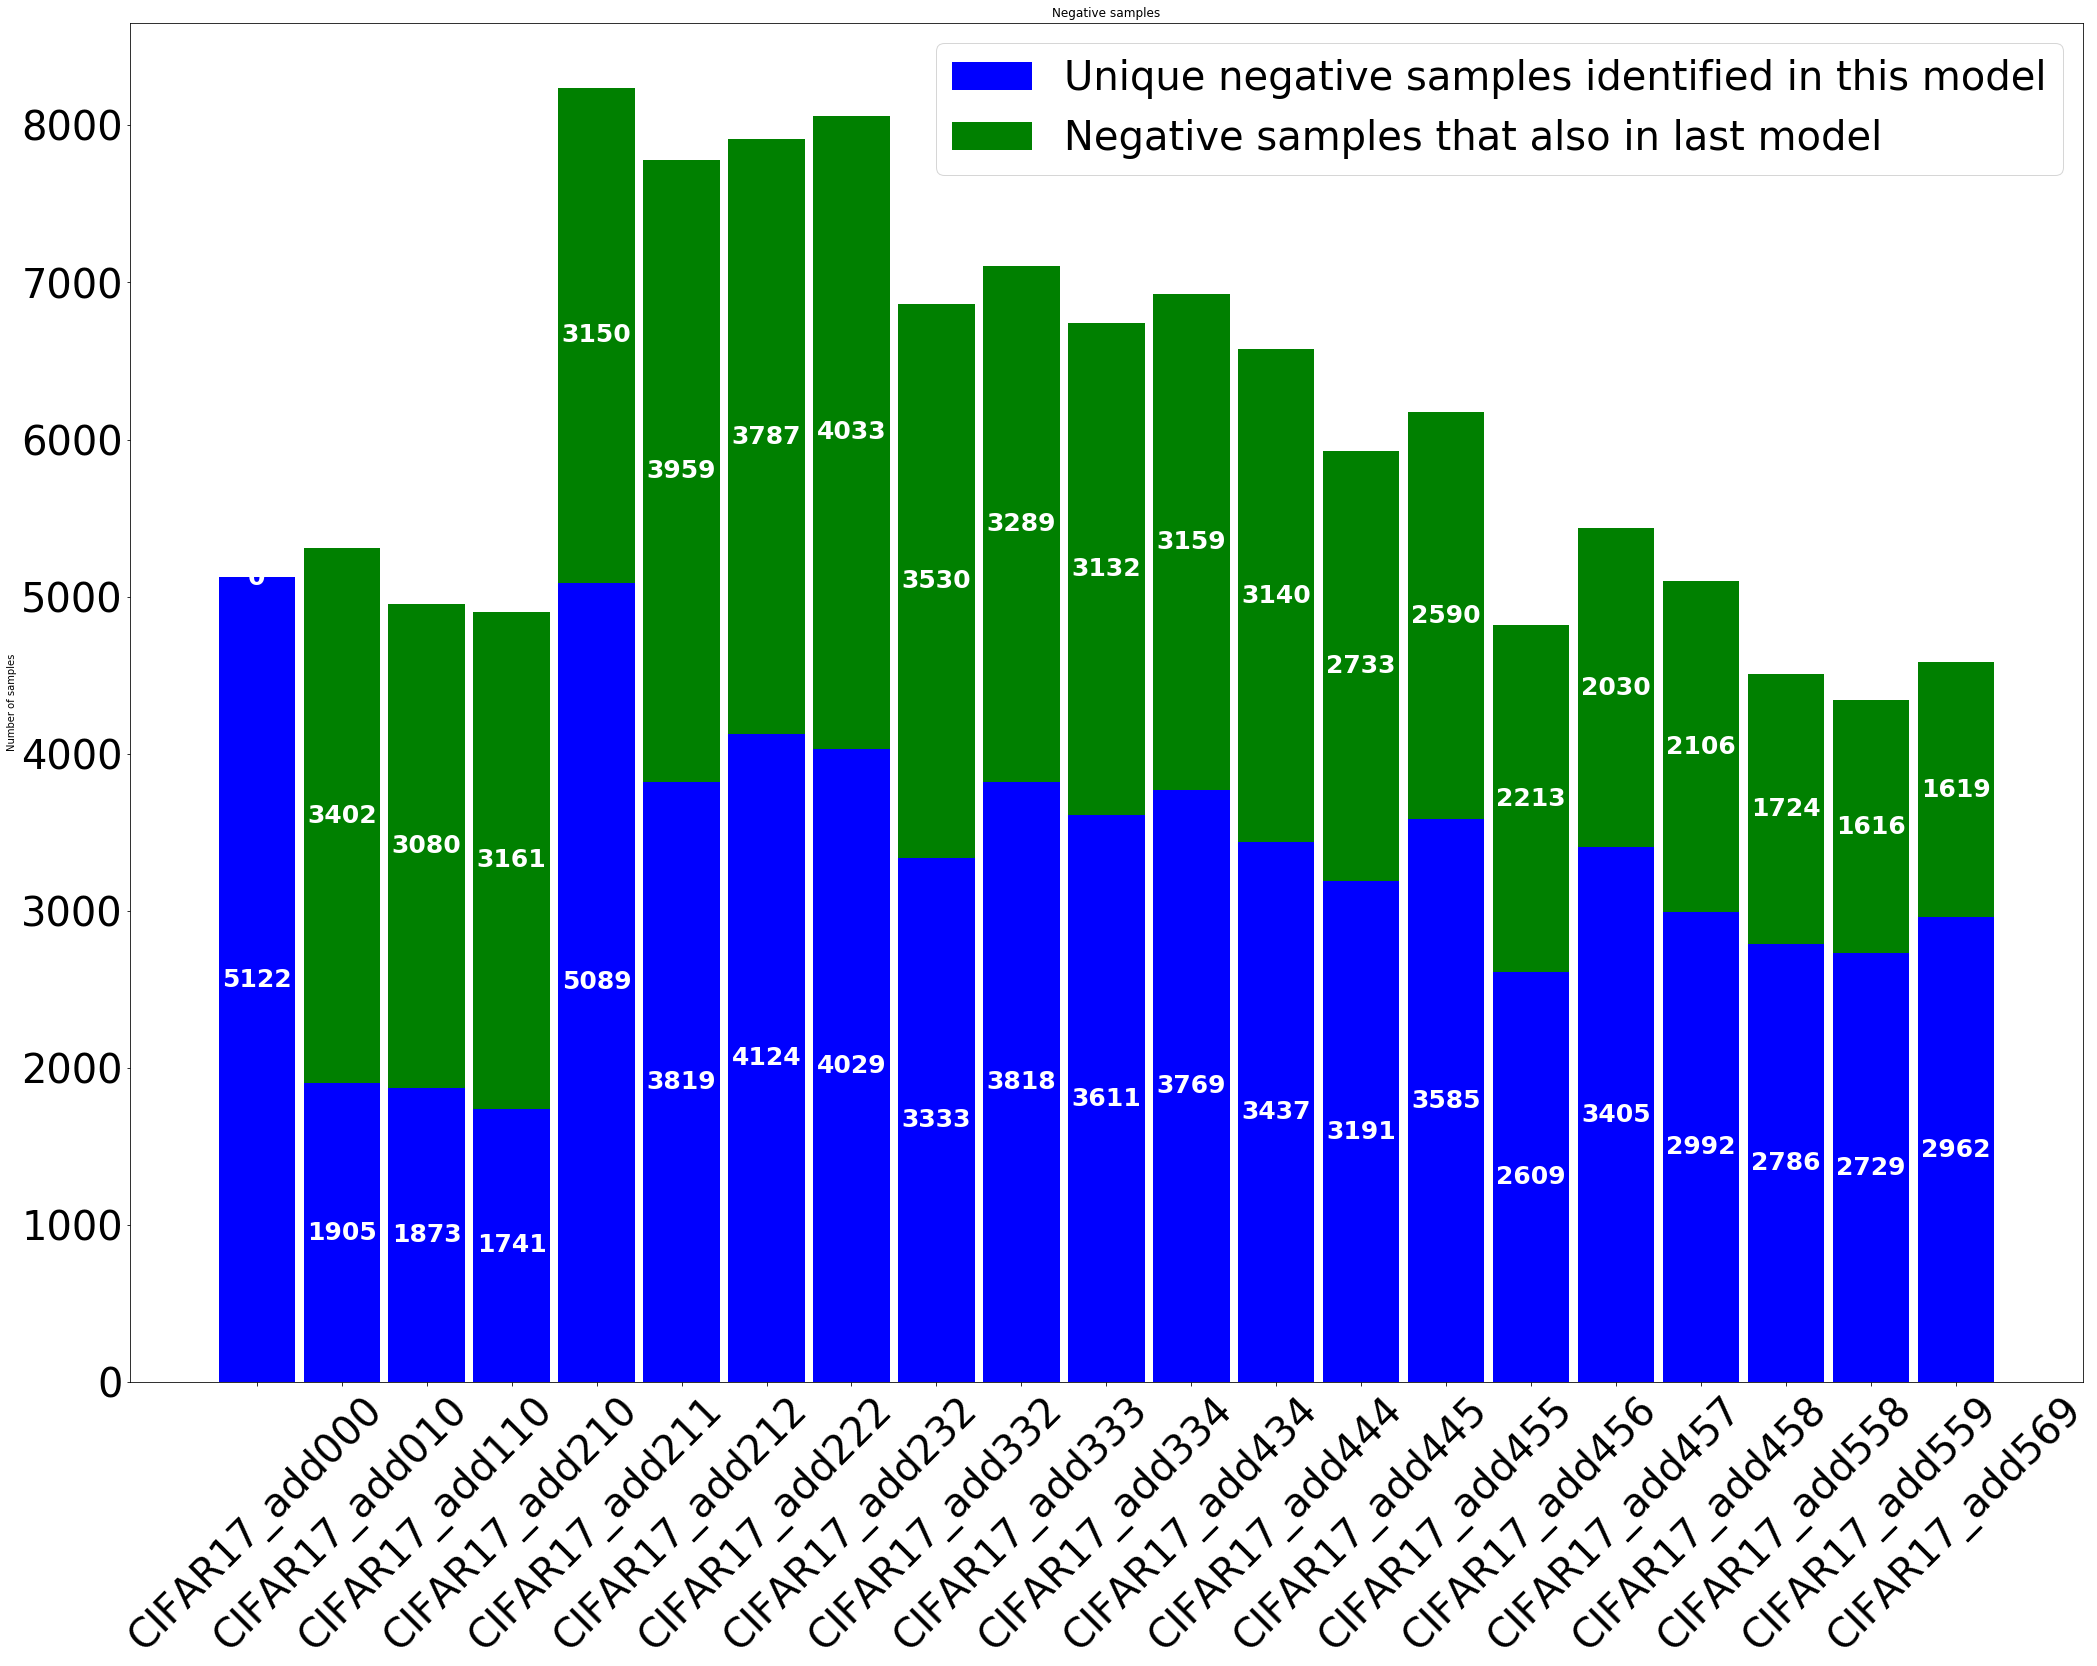

In [56]:
labels = initial_trace
unique = neg_unique_trace
overlap = neg_overlap_trace
width = 0.9 # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(35,25))

ax1 = ax.bar(labels, unique, width,  
             label='Unique negative samples identified in this model', color='blue')

ax2 = ax.bar(labels, overlap, width, bottom=unique, 
             label='Negative samples that also in last model', color='green')

#  add value labels
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="white", fontsize=25, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="white", fontsize=25, fontweight="bold")

ax.set_ylabel('Number of samples')
ax.set_title('Negative samples')
ax.legend(fontsize=40)
plt.xticks(rotation=45, fontsize=40)
plt.yticks(fontsize=40)

plt.show()